# Imports

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
# from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Todo:
- Calculate sensitivities for changes to:
    - interest rate chages : 
        (1) IRS to stabilize this (but with 2% lower rate?)
        (2) stochastic interest rate process?
    - volatility changes   : 
        (1) Options to hedge against excessive volatility ?
        (2) stochastic volatility process
- V0 for different mu guesses:
    - its not dependent on it

Distribution of phi/psi over:
- mu
- r

Short cummings:
- r, mu, sigma correlations
    - if we dont by IRS. Volatility of r could be correlated with volatility of sigma if both are stochastic processes
- mu is very speculative.
- values where its not profitable to offer this product


# Simulate W1 & W2 Pahs

In [14]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

In [15]:
""" Global Variables """
n_paths   = ceil(np.log2(4_000)) ; print(f'Paths: {2**n_paths:,.0f}')# for both Y and N
dt        = 1/(100) # Local: use greater than 42

rebalancing = 1/4 # Quarterly

P = 100 # premium per client
N = 10_000
ADJUSTMENT_FACTOR = P * N

Paths: 4,096


## Y - Geometric Brownian Motion

Number of steps: 1001 
dt         = 0.010 year
----------------------------------------------------------------
Time to simulate: 0.428sec
mean Yt    = 2.226179
e^(mu * T) = 2.225541 
Diff       = 0.000638


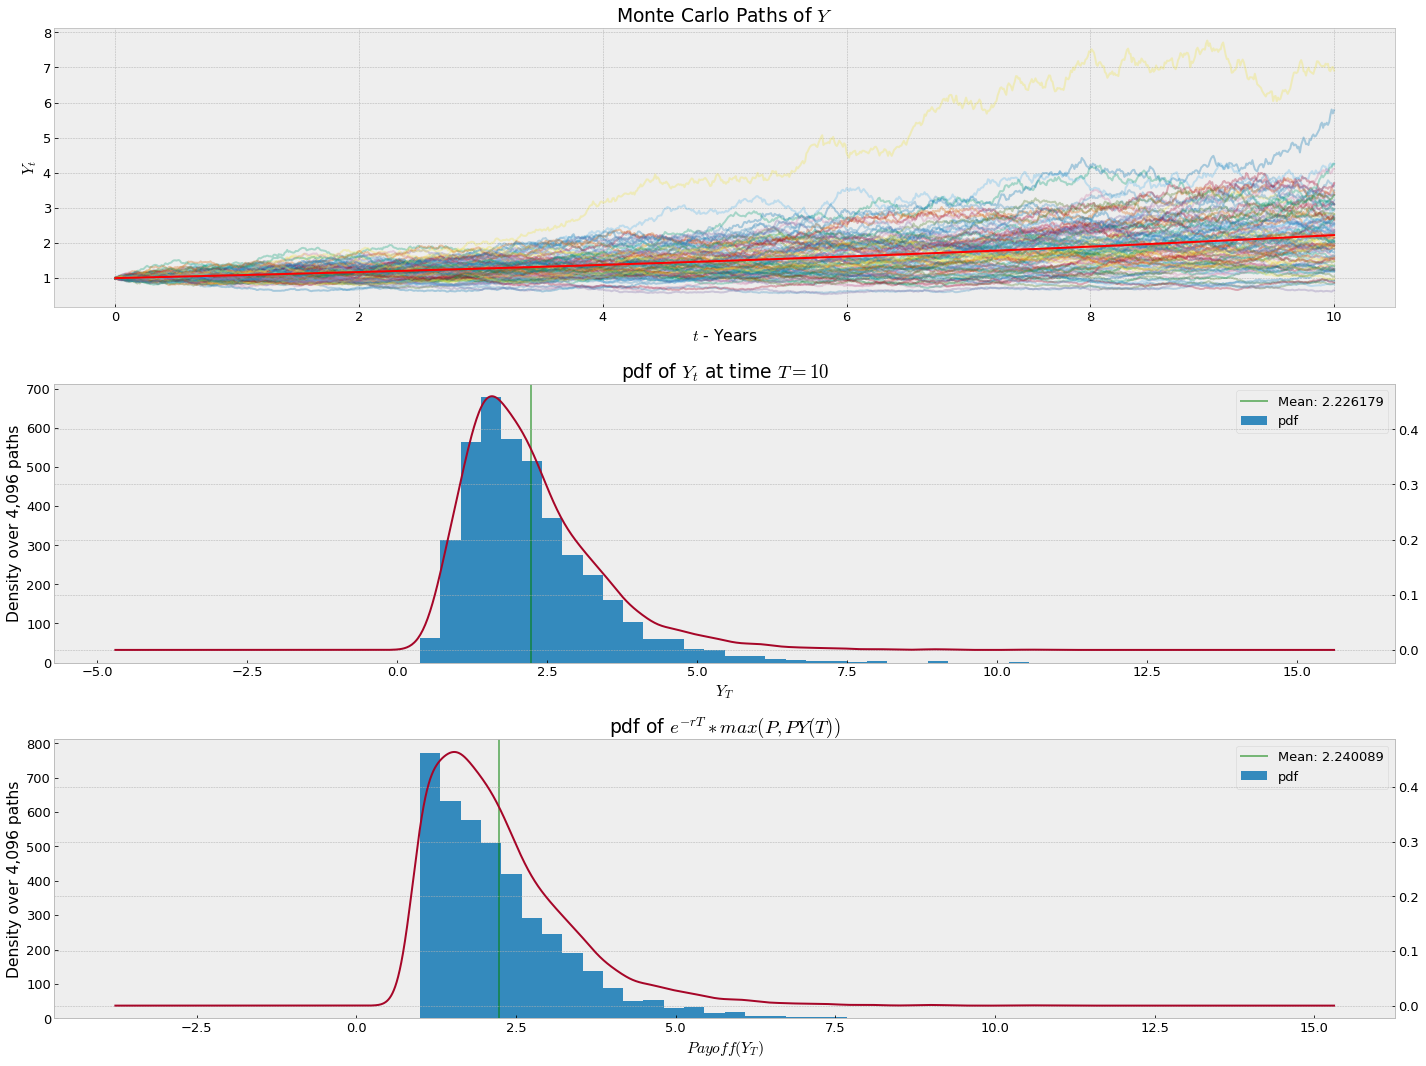

-------------------------------------
Expected Payoff = 2.240089
Discounted Expected Payoff = 1.659499
Prob Y < 1 = 7.74%


In [16]:
Y       = 1
T       = 10 # Years
mu      = 0.08 #0.09547935090766661
r       = 0.03
sigma   = 0.15

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

SV = 0
""" Cox-Ross - SV parameters - SPX parameters (40HV - 10 year lookback) """
v0 = 0.163351
a  = 0.0033405813052802035
b  = 0.1558604970991448
c  = 0.015832095331911343

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps)
W_SV    = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
# Y_paths[:,0] = np.log(Y)
Y_paths[:,0] = Y

""" SV - Verion """
vt = np.full(shape=(int(2**n_paths),n_time_steps), fill_value=v0) # initial variance 
print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    Y_paths[:,t] = Y_paths[:,t-1] + Y_paths[:,t-1] * (mu*dt + sigma * np.sqrt(dt)*W1[:,t]).squeeze()
    """ Advanced Version : continious time + Stochastic Volatility """
    # Simulate variance processes
    # vt[:,t] = vt[:,t-1] + a*(b - vt[:,t-1]) + c*np.sqrt(vt[:,t-1]*dt)*W_SV[:,t]
    # volatility = vt[:,t] if SV else sigma**2
    # # Simulate log asset prices
    # Y_paths[:,t] = Y_paths[:,t-1] + ((mu - 0.5*volatility**2)*dt + volatility*np.sqrt(dt)*W1[:,t])

# Y_paths = np.exp(Y_paths)

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

fig, axs = plt.subplots(3, figsize=(20,15))
print(f'mean Yt    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', ax=axs[0], title=r'Monte Carlo Paths of $Y$') 
axs[0].plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r')

rdf.iloc[-1,:].hist(bins=30, ax=axs[1])
rdf.iloc[-1,:].plot(kind='kde', secondary_y=True, title=r'pdf of $Y_t$ at time $T=10$', ax=axs[1])
axs[1].axvline(np.nanmean(Y_paths[:,-1]), color='g', linestyle='-', alpha=.5)
axs[1].legend([f'Mean: {np.nanmean(Y_paths[:,-1]):.6f}', 'pdf'])
axs[1].set_xlabel(r'$Y_T$') ; axs[1].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')

Payoff_Y     = np.where(Y_paths[:,-1] > Y, Y_paths[:,-1], Y)
E_Payoff_Y   = Payoff_Y.mean()
payoff_df = pd.Series(Payoff_Y)
payoff_df.hist(bins=30, ax=axs[2])
payoff_df.plot(kind='kde', ind=10_000, secondary_y=True, title=r'pdf of $e^{-rT}*max(P, PY(T))$', xlabel=r'Y_t', ylabel='Density over 10,000 paths', ax=axs[2])
axs[2].axvline(E_Payoff_Y, color='g', linestyle='-', alpha=.5)
axs[2].legend([f'Mean: {E_Payoff_Y:.6f}', 'pdf'])
axs[2].set_xlabel(r'$Payoff(Y_T)$') ; axs[2].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')
plt.tight_layout() ; plt.show()

print('-------------------------------------')
# SE_Payoff_Y     = Payoff_Y.reshape(128, -1).mean(axis=0).std(ddof=1) / np.sqrt(128)
out_of_money_P  = np.where(Y_paths[:,-1] < Y, 1.0, 0.0).mean()
print(f'Expected Payoff = {E_Payoff_Y:.6f}')
print(f'Discounted Expected Payoff = {np.exp(-r*T)*E_Payoff_Y:.6f}')
print(f'Prob Y < 1 = {out_of_money_P*100:.2f}%')

if SV:
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,T, n_time_steps), (vt).mean(axis=0), c='r')
    ax.plot(np.linspace(0,T, n_time_steps), (vt).std(axis=0) + (vt).mean(axis=0), c='tab:blue')
    ax.plot(np.linspace(0,T, n_time_steps), -(vt).std(axis=0) + (vt).mean(axis=0), c='tab:blue')
    ax.legend([r'$E[\sigma(t)]$', '$std(\sigma(t))$'])
    pd.DataFrame((vt).T, index=(np.linspace(0,T, n_time_steps)))\
        .sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\sqrt{\sigma_{stoch}}$', \
            xlabel=r'$t$ - Years', title='Monte Carlo Paths of Stochastic Volatility', ax=ax) 

# N(T) - Simulation

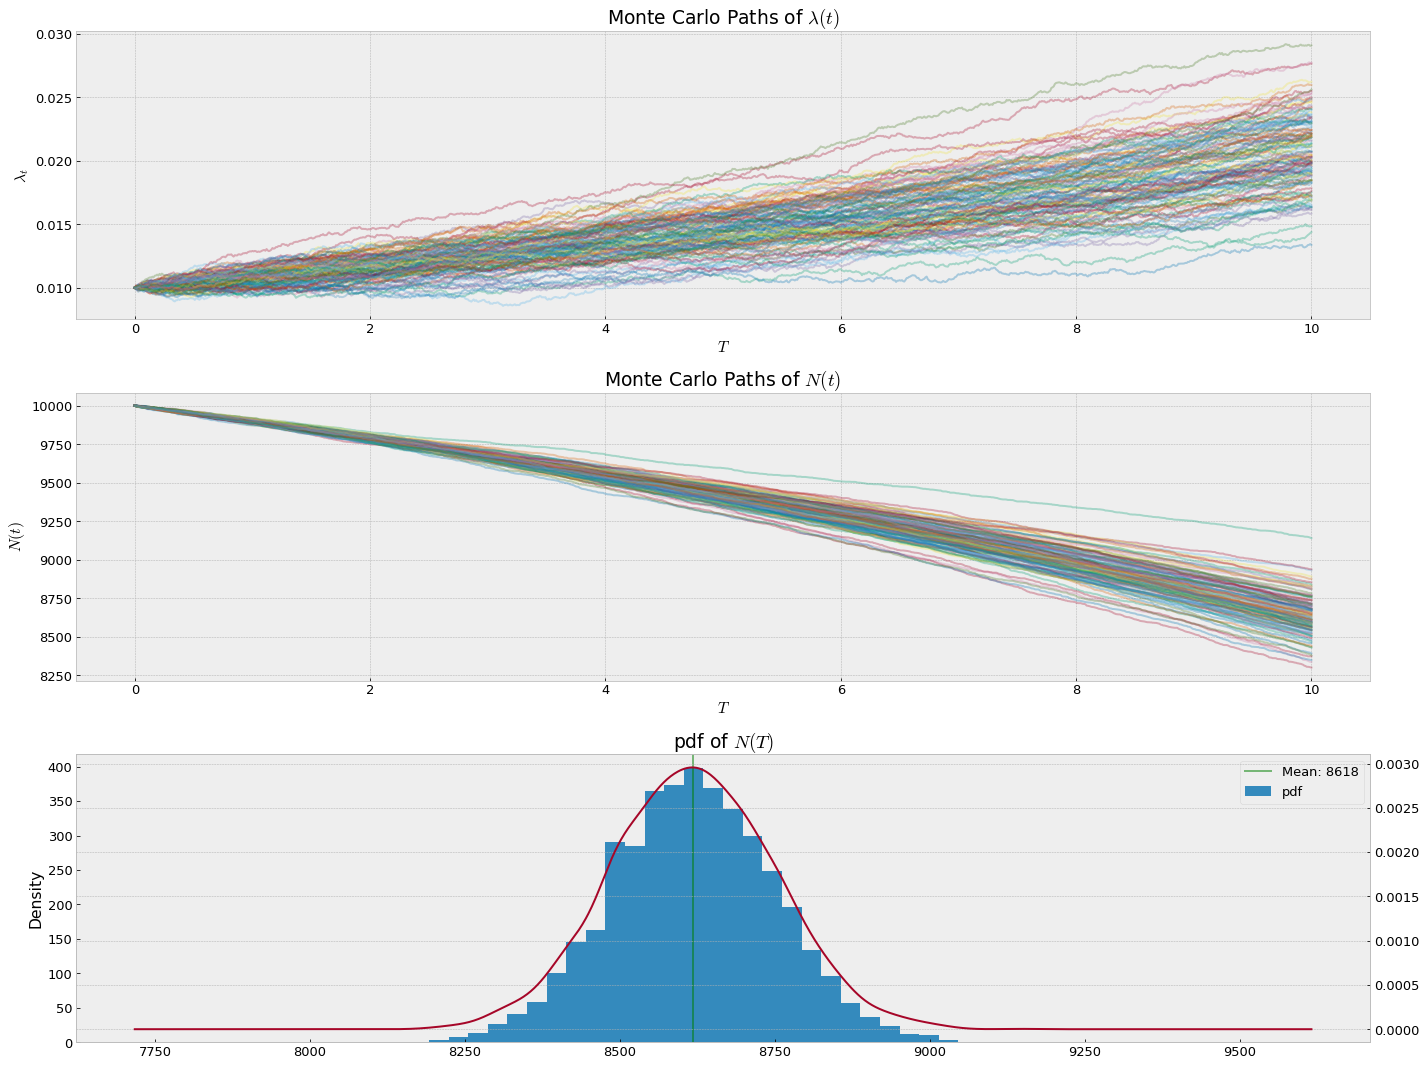

count   4,096
mean    8,618
std       132
min     8,192
50%     8,617
90%     8,786
95%     8,834
99%     8,933
max     9,141
--------------------------
Q99 N_T     = 8617.7 
Q99 SE      = 5.08
Q99_CI_95   = (8608, 8628)


In [17]:
x   = 55.0 # yo
l0  = 0.01
c   = 0.075
ita = 0.000597

""" Simulate Fund Price """
W2      = sobol_norm(n_paths, d=n_time_steps)
L_paths = np.empty((2**n_paths, n_time_steps))
L_paths[:,0] = l0
for t in range(1,n_time_steps):
    L_paths[:,t] = L_paths[:,t-1] + (c * L_paths[:,t-1] * dt + ita * np.sqrt(dt)*W2[:,t]).squeeze()

N_paths = np.empty((2**n_paths, n_time_steps), dtype=int)
N_paths[:,0] = N
""" Binomial Distribution of N(t) """
for t in range(1,n_time_steps):
    probabilities = np.exp(-L_paths[:,t]*dt)
    np.random.seed(1234+t) # to ensure reproducible results
    N_paths[:,t]  = np.random.binomial(N_paths[:,t-1], probabilities)

fig, axs = plt.subplots(3, figsize=(20,15))

rdf = pd.DataFrame(L_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\lambda_t$', xlabel=r'$T$', ax=axs[0], title=r'Monte Carlo Paths of $\lambda(t)$') 

rdf = pd.DataFrame(N_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$N(t)$', xlabel=r'$T$', ax=axs[1], title=r'Monte Carlo Paths of $N(t)$') 

E_N_T    = N_paths[:,-1].mean()

N_T = pd.Series(N_paths[ N_paths[:,-1]>0 ,-1])
N_T.hist(bins=30, ax=axs[2])
N_T.plot(kind='kde', secondary_y=True, title=r'pdf of $N(T)$', xlabel=r'N_T', ylabel='Density over 10,000 paths', ax=axs[2])
axs[2].axvline(E_N_T, color='g', linestyle='-', alpha=.5)
axs[2].legend([f'Mean: {E_N_T:.0f}', 'pdf'])
plt.tight_layout() ; plt.show()

N_T_df = pd.Series(N_T)
str_form = lambda s: f'{s:,.0f}'
print(N_T_df.describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))
Q99_N_T     = np.quantile(N_paths[:,-1], 0.99)
Q99_N_T_SE  = np.quantile(N_paths[:,-1].reshape(128, -1), 0.99, axis=1).std(ddof=1) / np.sqrt(128)
# del N_paths ; del L_paths ; del N_T_df

print('--------------------------')
print(f'Q99 N_T     = {E_N_T:.1f} \nQ99 SE      = {Q99_N_T_SE:.2f}')
print(f'Q99_CI_95   = ({E_N_T - 1.96*Q99_N_T_SE:.0f}, {E_N_T + 1.96*Q99_N_T_SE:.0f})')

In [18]:
reduction       = floor(n_time_steps/(T/rebalancing))-1 ;print(f'reduction = {reduction}')
Y_paths         = Y_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
N_paths         = N_paths[:, slice(0, None, reduction)]
n_time_steps  = ceil(n_time_steps/reduction) ; dt = dt *reduction

# Y_paths[:,-1].mean(), N_paths[:,-1].mean()

reduction = 24


# Expected Value of the Portfolio
The expected value of the portfolio should equal the discounted expected payoff of Y * the expected number of survivors. 

Expected S_T = 1,926,350 EUR


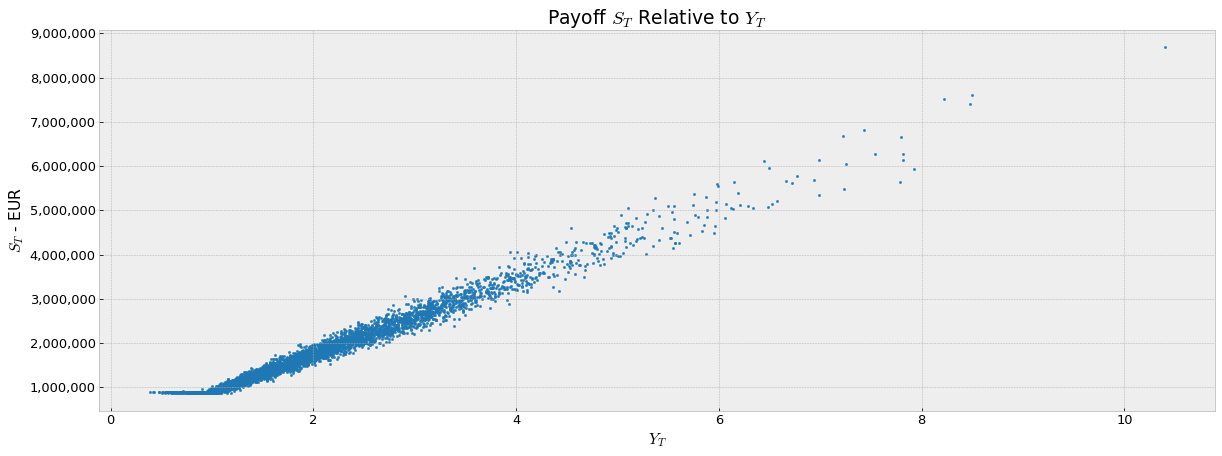

In [19]:
S_T = Payoff_Y * N_paths[:, -1] * P
_in = {'S_T': S_T, 'Y_T': Y_paths[:,-1]}
ax = pd.DataFrame.from_dict(_in).plot(kind='scatter', x='Y_T', y='S_T',xlabel=r'$Y_T$',ylabel=r'$S_T$ - EUR', title=r'Payoff $S_T$ Relative to $Y_T$', marker='.', color='tab:blue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
print(f'Expected S_T = {S_T.mean():,.0f} EUR')

# Neural Network Hedging

In [20]:
def get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values, Y_t, B_t):
    layer_output1=model1.get_layer('Phi_Psi').output
    pw_model1 = Model(inputs=[model1.input], outputs=[layer_output1])

    linear_layer_output1 = pw_model1.predict(X0)

    layer_output2 = model2.get_layer('Phi_Psi').output
    pw_model2 = Model(inputs=[model2.input], outputs=[layer_output2])

    linear_layer_output2 = pw_model2.predict(X0)

    phi = linear_layer_output1[:,0] + cost_of_capital * (linear_layer_output1[:,0] - linear_layer_output2[:,0])
    psi = linear_layer_output1[:,1] + cost_of_capital * (linear_layer_output1[:,1] - linear_layer_output2[:,1])

    for f  in phi: Phi_Psi_HV.append([f,  t_i*dt, 'Phi'])
    for ps in psi: Phi_Psi_HV.append([ps, t_i*dt, 'Psi'])

    VaR = values - phi * Y_t - psi * B_t

    # print(f'VaR: {np.quantile(VaR, .98):4f} (98%),  {np.quantile(VaR, .99):4f} (99%)')

    for var in VaR: VaR_HV.append([var, t_i*dt+dt])
    
    return Phi_Psi_HV, VaR_HV


def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

@tf_fun
def quantile_loss(y, y_p):
        quantile = .99
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(quantile*e, (quantile-1)*e))

lr_scheduler    = keras.callbacks.LearningRateScheduler(scheduler)
quantile_loss_f = lambda y, y_p : quantile_loss(y, y_p)

In [21]:
cost_of_capital = 0.1 * dt

In [22]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)

Input_S_N = keras.Input(shape=(3,), name='input: S_{t}, N_{t}') 
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model1 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio1")
model2 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio2")
# model.summary()
#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse', run_eagerly=False, 
              metrics=["mae", "mape"])
model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = quantile_loss_f, run_eagerly=False, 
              metrics=["mae", "mape"])

N_paths_NN      = N_paths / N
values          = np.empty_like(Y_paths)
values[:,-1]    = Payoff_Y * N_paths_NN[:,-1] 
E_payoff        = (values[:,-1]).mean()

""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,3)) * values[:,-1].mean()
VaR_HV      = []
Phi_Psi_HV  = []
for t_i in trange(n_time_steps-2, -1, -1):
    print(f'Y_({(t_i+1)*dt:.2f}) = {values[:,t_i+1].mean():.3f}, N_({(t_i+1)*dt:.2f}) = {N_paths_NN[:,t_i+1].mean():.3f}')
    _Y_t  = Y_paths[:,t_i]
    _B_t  = B[:,t_i]
    _Y_t1 = Y_paths[:,t_i+1]
    _B_t1 = B[:,t_i+1]

    X0 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t, _B_t), axis=-1)]
    X1 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t1, _B_t1), axis=-1)]

    epochs = 500
    if Flag :
        # print(f'S.mean: {S.mean():.5f}\nP.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
        callabacks = [lr_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
    else : 
        epochs = 100 
        callabacks = [callback]

    model1.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    g_t  = model1.predict(X0, verbose=0, batch_size=512).squeeze()
    g_t1 = model1.predict(X1, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model1.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0)
    
    model2.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)    
    h_t  = model2.predict(X0, verbose=0, batch_size=512).squeeze()
    h_t1 = model2.predict(X1, verbose=0, batch_size=512).squeeze()

    values[:,t_i] = g_t + cost_of_capital*(h_t - g_t)

    """ Update phi-psi and VaR """
    Phi_Psi_HV, VaR_HV = get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values[:,t_i+1], _Y_t1, _B_t1)

    its += 1 ; Flag = False 
    P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), E_payoff*np.exp(-mu*dt*its), E_payoff*np.exp(-r*dt*its)]).reshape(1,3), axis=0)


  0%|          | 0/41 [00:00<?, ?it/s]

Y_(9.84) = 1.926, N_(9.84) = 0.865
8/8 [==============================] - 0s 4ms/step - loss: 0.0171 - mae: 0.0932 - mape: 4.7856
Y_(9.60) = 1.897, N_(9.60) = 0.869
8/8 [==============================] - 0s 4ms/step - loss: 2.1135e-04 - mae: 0.0086 - mape: 0.6168
Y_(9.36) = 1.861, N_(9.36) = 0.873
8/8 [==============================] - 0s 4ms/step - loss: 1.1645e-04 - mae: 0.0039 - mape: 0.3466
Y_(9.12) = 1.826, N_(9.12) = 0.877
8/8 [==============================] - 0s 4ms/step - loss: 9.2516e-05 - mae: 0.0034 - mape: 0.3154
Y_(8.88) = 1.793, N_(8.88) = 0.882
8/8 [==============================] - 0s 4ms/step - loss: 7.4252e-05 - mae: 0.0031 - mape: 0.2897
Y_(8.64) = 1.760, N_(8.64) = 0.886
8/8 [==============================] - 0s 4ms/step - loss: 6.5664e-05 - mae: 0.0034 - mape: 0.3046
Y_(8.40) = 1.728, N_(8.40) = 0.890
8/8 [==============================] - 0s 4ms/step - loss: 5.6765e-05 - mae: 0.0034 - mape: 0.3005
Y_(8.16) = 1.696, N_(8.16) = 0.894
8/8 [==========================

# Residuals - VaR
* Add N(t) Notation
* 3 graphs - payoff , first hedge and after the last

In [23]:
VaR_HV_df = pd.DataFrame(np.array(VaR_HV)[:,0], index=np.array(VaR_HV)[:,1], columns=['VaR'])
residuals = VaR_HV_df.loc[10].values * ADJUSTMENT_FACTOR
c = ['tab:red' if r else 'tab:blue' for r in residuals > 0]
fig, ax = plt.subplots()
plt.scatter(Y_paths[:,-1]* ADJUSTMENT_FACTOR, residuals, color=c, marker='.')
plt.xlabel(r'$Y_{T}$ - EUR'), plt.ylabel('Residuals - EUR')
plt.title(r'Residuals : $Payoff_T - \phi(T-1)Y_T - \psi(T-1)B_T$')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

KeyError: 10

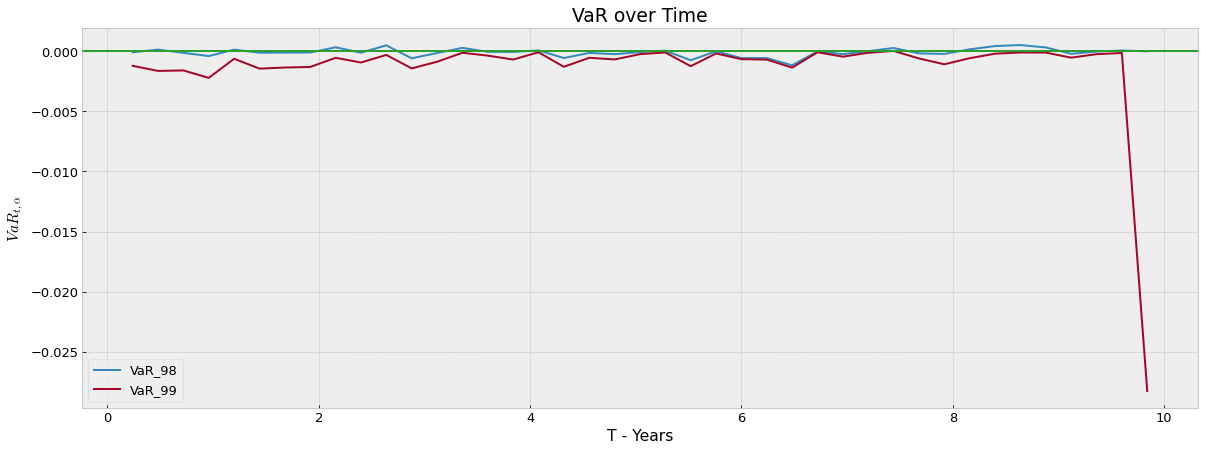

Overall VaR(98.5%) = -0.00018
Overall VaR(99.0%) = 0.00001
Overall VaR(99.5%) = 0.00094


In [24]:
ax = VaR_HV_df.groupby(level=0).aggregate(
    VaR_98=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .99)),
    VaR_99=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .98)),
    ).plot(title=r'VaR over Time', xlabel='T - Years', ylabel=r'$VaR_{t,\alpha}$')
ax.axhline(0, color='tab:green') ; plt.show()
print(f'Overall VaR(98.5%) = {np.quantile(VaR_HV_df.values, .985):.5f}')
print(f'Overall VaR(99.0%) = {np.quantile(VaR_HV_df.values, .99):.5f}')
print(f'Overall VaR(99.5%) = {np.quantile(VaR_HV_df.values, .995):.5f}')

# Hedging Values

Phi t=0 : 721,736 Stocks
Psi t=0 : 223,770 Bonds


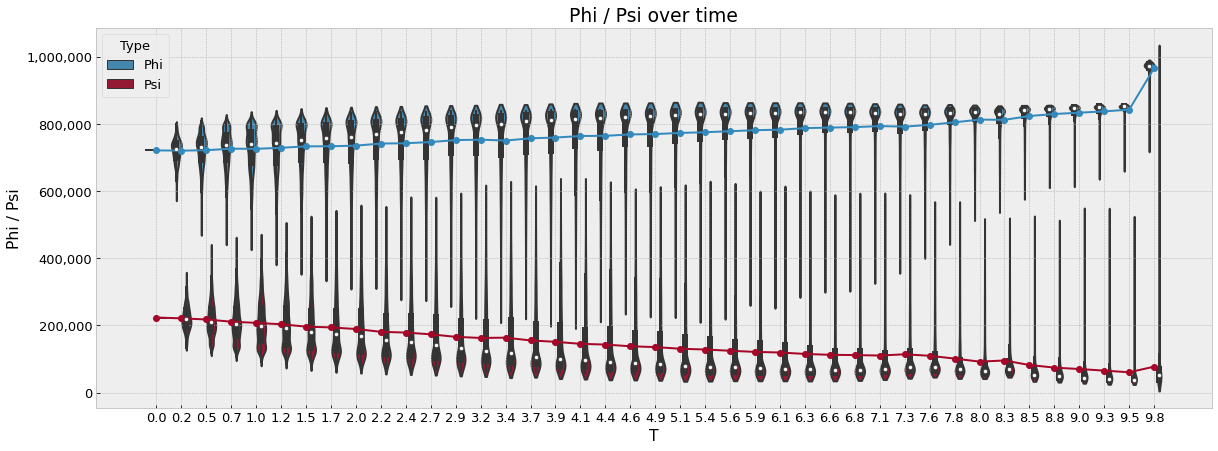

In [25]:
index = np.linspace(0, T, n_time_steps-1, endpoint = False)[::-1]
phi_psi_df = pd.DataFrame(Phi_Psi_HV, columns=['Value', 'T', 'Type'])
phi_psi_df.Value *= ADJUSTMENT_FACTOR 

ax = sns.violinplot(data=phi_psi_df, x="T", y="Value", hue="Type", dodge=1, cut=True)
ax.set_xticklabels([f'{x:,.1f}'for x in index][::-1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

_ppg = phi_psi_df.groupby(['T', 'Type']).agg('mean')

title = 'Distribution of Phi/Psi over time'
phidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Phi'].groupby('T').mean().rename(columns={'Value':'Mean Phi'})['Mean Phi']
psidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Psi'].groupby('T').mean().rename(columns={'Value':'Mean Psi'})['Mean Psi']
phidf.index = range(0, phidf.shape[0]) ; psidf.index = range(0, psidf.shape[0])
phidf.plot(marker='o', ax=ax) ; psidf.plot(marker='o', ax=ax) ; 
ax.set_ylabel('Phi / Psi') ; ax.set_title('Phi / Psi over time') #; ax.set_xlabel('T - Years')

print(f'Phi t=0 : {_ppg.loc[(0, "Phi")].mean():,.0f} Stocks')
print(f'Psi t=0 : {_ppg.loc[(0, "Psi")].mean():,.0f} Bonds')

# _ppg

ADJUSTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 938,279.450
Discounted Eq[S] ADJ          = 1,427,074.896
 Difference                   = -488,795.446 : -34.252%
Discounted Ep[S] ADJ          = 865,564.678
 Difference                   = 72,714.772   : 8.401% 
Total Premium at t0           = 1,000,000 
Profit w/o TC                 = 61,721


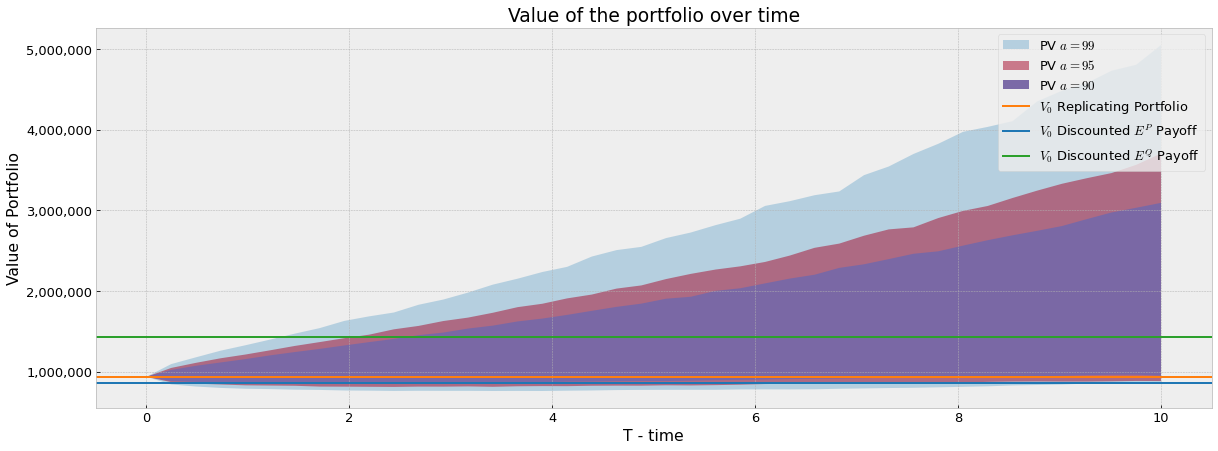

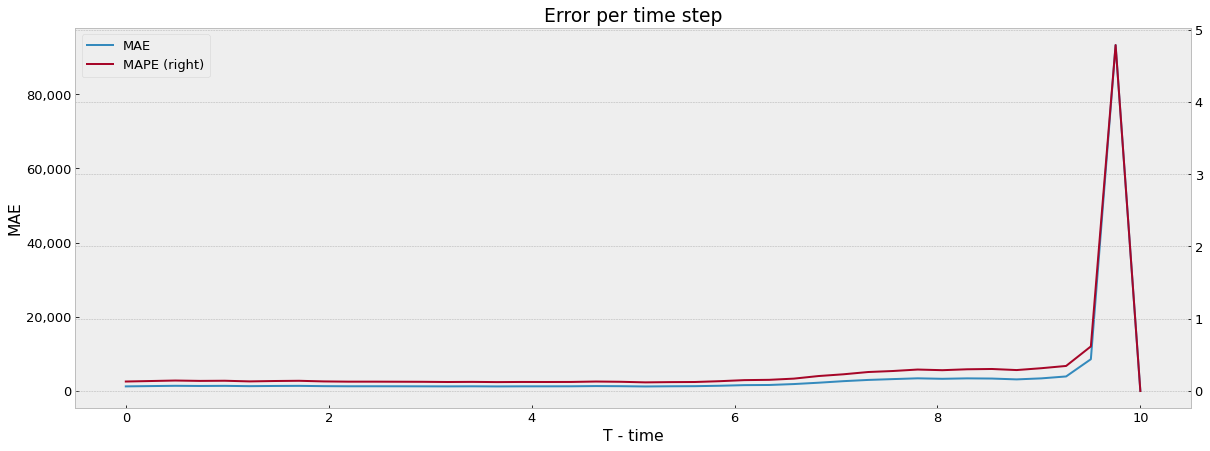

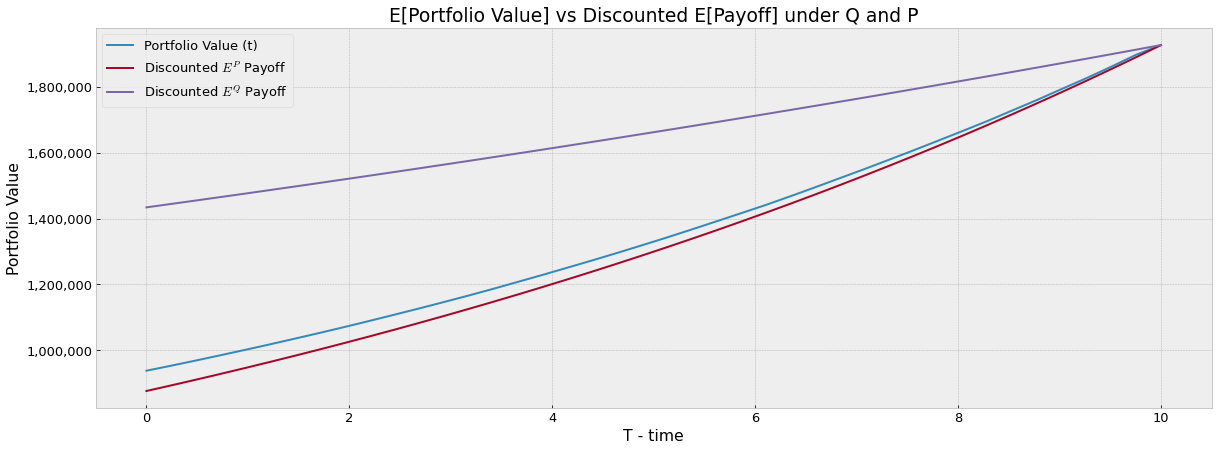

In [28]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(S_T.mean() * np.exp(-mu*T), color='tab:blue')
ax.axhline(S_T.mean() * np.exp(-r*T), color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^P$ Payoff', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUSTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[S] ADJ          = {S_T.mean() * np.exp(-r*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-r*T):,.3f} : {(V0_RP - S_T.mean() * np.exp(-r*T))/(S_T.mean() * np.exp(-r*T)) * 100:,.3f}%')
print(f'Discounted Ep[S] ADJ          = {S_T.mean() * np.exp(-mu*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-mu*T):,.3f}   : {(V0_RP - S_T.mean() * np.exp(-mu*T))/ (S_T.mean() * np.exp(-mu*T)) * 100:,.3f}% ')
print(f'Total Premium at t0           = {ADJUSTMENT_FACTOR:,} \nProfit w/o TC                 = {ADJUSTMENT_FACTOR - V0_RP:,.0f}')

Errors_df = pd.DataFrame(np.array(Errors[::-1]), index=t, columns=['MAE', 'MAPE'])
Errors_df['MAE'] = Errors_df['MAE'] * ADJUSTMENT_FACTOR
ax = Errors_df.plot(legend=True, title='Error per time step', ylabel='MAE', secondary_y=['MAPE'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

E_Port_Values_df = pd.DataFrame(np.array(P_E_Values[::-1]), index=t, columns=['Portfolio Value (t)', r'Discounted $E^P$ Payoff', r'Discounted $E^Q$ Payoff']) * ADJUSTMENT_FACTOR
ax = E_Port_Values_df.plot(legend=True, title='E[Portfolio Value] vs Discounted E[Payoff] under Q and P', ylabel='Portfolio Value')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

plt.show()

# Hedging Simulations

In [ ]:
parameters = {
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(2),
    'SV' : False,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,        # mean reversion rate
    's_vol' : 0.1,         # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 1,

    'T'   : 10,
    'N'   : 10_000,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,
    'dt'  : 1/(42),  # Monthly steps
    'n_paths_N' : ceil(np.log2(1_000))
}

In [ ]:
import Replicating_Portfolio as RP
reload(RP)

IP = RP.Insurance_Portfolio(parameters, simulate=False)

rebalancing = 1/2 # quarterly

""" Step 1: Set up Y and N paths """
_y_reduction = floor(Y_paths.shape[1] / (T/rebalancing))
_n_reduction = floor(N_paths.shape[1] / (T/rebalancing))

Ypath = Y_paths[0,slice(0,None, _y_reduction)]
Npath = N_paths[0,slice(0,None, _n_reduction)]

""" Step 2: iterate over T """
tarray = np.linspace(0,T, Ypath.shape[0])
Results = {}
for idx in trange(Ypath.shape[0]):
    Yt = Ypath[idx]
    Nt = Npath[idx]
    
    # Calculate survival_rate
    parameters['N'] = Nt
    parameters['T'] = T - tarray[idx]
    print(survaval_parameters)
    N_t = RP.Simulate_N_T_outcomes(survaval_parameters)
    _Q99_N_T     = np.quantile(N_t, 0.99)

    # Calculate Replicating Portfolio Value and phi_psi values
    changed_parameters = {
    'Y': Yt,
    'T': T - tarray[idx],
    'survival_rate': _Q99_N_T/Nt,
    'ADJUSTMENT_FACTOR' : 100*Nt
    }
    print(changed_parameters)
    V0, PP = IP.Replicaitng_Portfolio_V0(changed_param=changed_parameters, make_plots=False, print_info=False, return_phi_psi=True)
    Results[tarray[idx]] = [Yt, Nt, V0, PP[0], PP[1]]
    

KeyError: 'ADJUSTMENT_FACTOR'

In [ ]:
Results_df = pd.DataFrame.from_dict(Results, orient='index')#, columns=['Yt', 'Nt', 'RP_Vt', 'Phi', 'Psi'])
Results_df.columns = ['Yt', 'Nt', 'RP_Vt', 'Phi', 'Psi']
Results_df.index.name = 't'
Results_df


,Yt,Nt,RP_Vt,Phi,Psi
t,,,,,
0.0,1.000000,10000,9.344933e+05,0.773144,0.161349
0.5,0.894844,9939,8.403456e+05,0.791483,0.132092
1.0,0.909405,9888,8.638117e+05,0.792046,0.143521
1.5,1.005148,9841,9.620678e+05,0.762952,0.195188
2.0,1.001123,9786,9.640492e+05,0.791640,0.171520
2.5,1.096884,9731,1.068288e+06,0.769499,0.224236
3.0,1.316253,9670,1.295843e+06,0.751563,0.306596
3.5,1.371754,9613,1.352717e+06,0.752812,0.320044
4.0,1.624419,9545,1.620206e+06,0.743184,0.412964


In [ ]:
import Replicating_Portfolio as RP
reload(RP)

parameters = {
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(2),
    'SV' : False,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,        # mean reversion rate
    's_vol' : 0.1,         # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 1,

    'T'   : 10,
    'N'   : 10_000,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,
    'dt_n'  : 1/(42),  # Monthly steps
    'n_paths_N' : ceil(np.log2(1_000))
}

res = RP.Calculate_V0_Phi_Psi(**parameters)

res

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


(1048899.2929458618, 0.8563199, 0.19257939)

# Sensitivies

In [ ]:
from importlib import reload
import Replicating_Portfolio
reload(Replicating_Portfolio)

parameters = {
    'Y'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(100),
    'SV' : True,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,         # mean reversion rate
    's_vol' : 0.1,        # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 25,
    'survival_rate': Q99_N_T/N,
    'ADJUSTMENT_FACTOR':ADJUSTMENT_FACTOR,
    
}

IP = Replicating_Portfolio.Insurance_Portfolio(parameters, simulate=False)
""" IP options: 
Value           -  pamam_change : dict
sensitivity     -  param : dict
"""
# Over sigma
_sigmas = [.01, .05, .1, .15, .2, .25, .3]
_V0_s    = []
for _sigma in _sigmas:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('sigma', _sigma), make_plots=False, print_info=False)
    print(_sigma, _V0)
    _V0_s.append(_V0)

# Over r
_rhos   = [.00, .01, .02, .03, .04, .05, .06]
_V0s_r  = []
for _rho in _rhos:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('r', _rho), make_plots=False, print_info=False)
    print(_rho, _V0)
    _V0s_r.append(_V0)

# Over mu
_mus    = [.01, .02, .04, .06, .08, .12]
_V0s_mu = []
for _mu in _mus:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('mu', mu), make_plots=False, print_info=False)
    print(_mu, _V0)
    _V0s_mu.append(_V0)

_V0_s = pd.Series(_V0_s, index=_sigmas)
_V0_s.name = 'RP Value over simga' ; _V0_s.index.name = 'sigma'

_V0s_r = pd.Series(_V0s_r, index=_rhos)
_V0s_r.name = 'RP Value over Rho' ; _V0s_r.index.name = 'rho'

_V0s_mu = pd.Series(_V0s_mu, index=_mus)
_V0s_mu.name = 'RP Value over Rho' ; _V0s_mu.index.name = 'mu'

str_form = lambda s: f'{s:,.0f} EUR'
print(f'OVER SIGMA \n-------------------------')
print(_V0_s.to_string(float_format=str_form))
print(f'\n\nOVER RHO \n-------------------------')
print(_V0s_r.to_string(float_format=str_form))
print(f'\n\nOVER MU \n-------------------------')
print(_V0s_mu.to_string(float_format=str_form))

OVER SIGMA 
-------------------------
sigma
0.00             NaN
0.01             NaN
0.02     896,534 EUR
0.03     934,882 EUR
0.04     976,676 EUR
0.05   1,009,529 EUR
0.06   1,031,368 EUR


OVER RHO 
-------------------------
rho
0.00   1,017,191 EUR
0.01     982,426 EUR
0.02     952,596 EUR
0.03     934,882 EUR
0.04     922,329 EUR
0.05     912,798 EUR
0.06     906,062 EUR


OVER MU 
-------------------------
mu
0.01   934,882 EUR
0.02   934,882 EUR
0.04   934,882 EUR
0.06   934,882 EUR
0.08   934,882 EUR
0.12   934,882 EUR
